In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
threshold = 500

In [3]:
train = pd.read_csv(f'data/split/train_M.csv')
test = pd.read_csv(f'data/split/test_M.csv')

In [4]:
df = train
matrix = pd.pivot_table(df, values="Status", index=["Stratification"], columns=["Climber_1000"]).fillna(0)

In [5]:
# Convert to Category
train['Climber_code'] = train[f'Climber_{threshold}'].astype('category').cat.codes
train['Stratification_code'] = train['Stratification'].astype('category').cat.codes

test['Climber_code'] = test[f'Climber_{threshold}'].astype('category').cat.codes
test['Stratification_code'] = test['Stratification'].astype('category').cat.codes

# Convert to tensor
train_values   = torch.tensor(train['Status'].values, dtype=torch.float32)
train_climbers = torch.tensor(train['Climber_code'].values, dtype=torch.long)
train_problems = torch.tensor(train['Stratification_code'].values, dtype=torch.long)

test_values   = torch.tensor(test['Status'].values, dtype=torch.float32)
test_climbers = torch.tensor(test['Climber_code'].values, dtype=torch.long)
test_problems = torch.tensor(test['Stratification_code'].values, dtype=torch.long)

# # train['Stratification'].value_counts().value_counts(normalize=True)

In [6]:
class PMF(nn.Module):
    def __init__(self, num_climbers, num_problems, num_factors):
        super(PMF, self).__init__()
        self.climber_embedding = nn.Embedding(num_climbers, num_factors)
        self.problem_embedding = nn.Embedding(num_problems, num_factors)

    def forward(self, climber_indices, problem_indices):
        climber_vector = self.climber_embedding(climber_indices)
        problem_vector = self.problem_embedding(problem_indices)
        dot_product = (climber_vector * problem_vector).sum(dim=1)
        outputs = torch.sigmoid(dot_product)
        return outputs

# Training function
def train_model(model, train_climbers, train_problems, train_values, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(train_climbers, train_problems)
        loss = criterion(predictions, train_values)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Prediction function
def predict(model, climber_indices, problem_indices):
    model.eval()
    with torch.no_grad():
        predictions = model(climber_indices, problem_indices)
    return predictions

# Extract and map embeddings to names
def extract_embeddings(model, encoder, embedding_layer, column_name):
    embeddings = embedding_layer.weight.data.cpu().numpy()
    names = encoder.inverse_transform(np.arange(len(embeddings)))
    df = pd.DataFrame(embeddings, index=names)
    df.index.name = column_name
    return df

# Clustering and visualization function
def cluster_and_visualize(embeddings_df, title):
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings_df.values)
    embeddings_df['Cluster'] = kmeans.labels_

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=embeddings_df[0], y=embeddings_df[1], hue=embeddings_df['Cluster'], palette='viridis', s=100)
    for line in range(0, embeddings_df.shape[0]):
        plt.text(embeddings_df[0][line], embeddings_df[1][line], embeddings_df.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.title(title)
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.legend(title='Cluster')
    plt.show()

# Initialize and train the model
num_factors = 2
num_climbers = train[f'Climber_{threshold}'].nunique()
num_problems = train['Stratification'].nunique()

model = PMF(num_climbers, num_problems, num_factors)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Train the model
num_epochs = 1000
train_model(model, train_climbers, train_problems, train_values, criterion, optimizer, num_epochs)

Epoch 100/1000, Loss: 0.4432872533798218
Epoch 200/1000, Loss: 0.43711575865745544
Epoch 300/1000, Loss: 0.43598759174346924
Epoch 400/1000, Loss: 0.4353415071964264
Epoch 500/1000, Loss: 0.4348796010017395
Epoch 600/1000, Loss: 0.4345041811466217
Epoch 700/1000, Loss: 0.43419259786605835
Epoch 800/1000, Loss: 0.4339354634284973
Epoch 900/1000, Loss: 0.433724582195282
Epoch 1000/1000, Loss: 0.4336560368537903


In [7]:
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [8]:
# Make predictions on the test data
test_predictions = predict(model, test_climbers, test_problems)
test_predictions_binary = np.round(test_predictions.numpy())

accuracy = accuracy_score(test_values.numpy(), test_predictions_binary)
log_loss = log_loss(test_values.numpy(), test_predictions)
brier_score = brier_score_loss(test_values.numpy(), test_predictions)
f1_score = f1_score(test_values.numpy(), test_predictions_binary)
roc_score = roc_auc_score(test_values.numpy(), test_predictions)

print(f'Test Accuracy: {accuracy}')
print(f'Log Loss: {log_loss}')
print(f'Brier Score: {brier_score}')
print(f'F1 Score: {f1_score}')
print(f'ROC Score: {accuracy}')

Test Accuracy: 0.7466267653698745
Log Loss: 0.7057693972337991
Brier Score: 0.1717847006521501
F1 Score: 0.7695540063031229
ROC Score: 0.7466267653698745


/var/folders/vw/h6mk20s92673927lzr84l52r0000gn/T/ipykernel_47898/3102733432.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(embeddings_df[0][line], embeddings_df[1][line], embeddings_df.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')


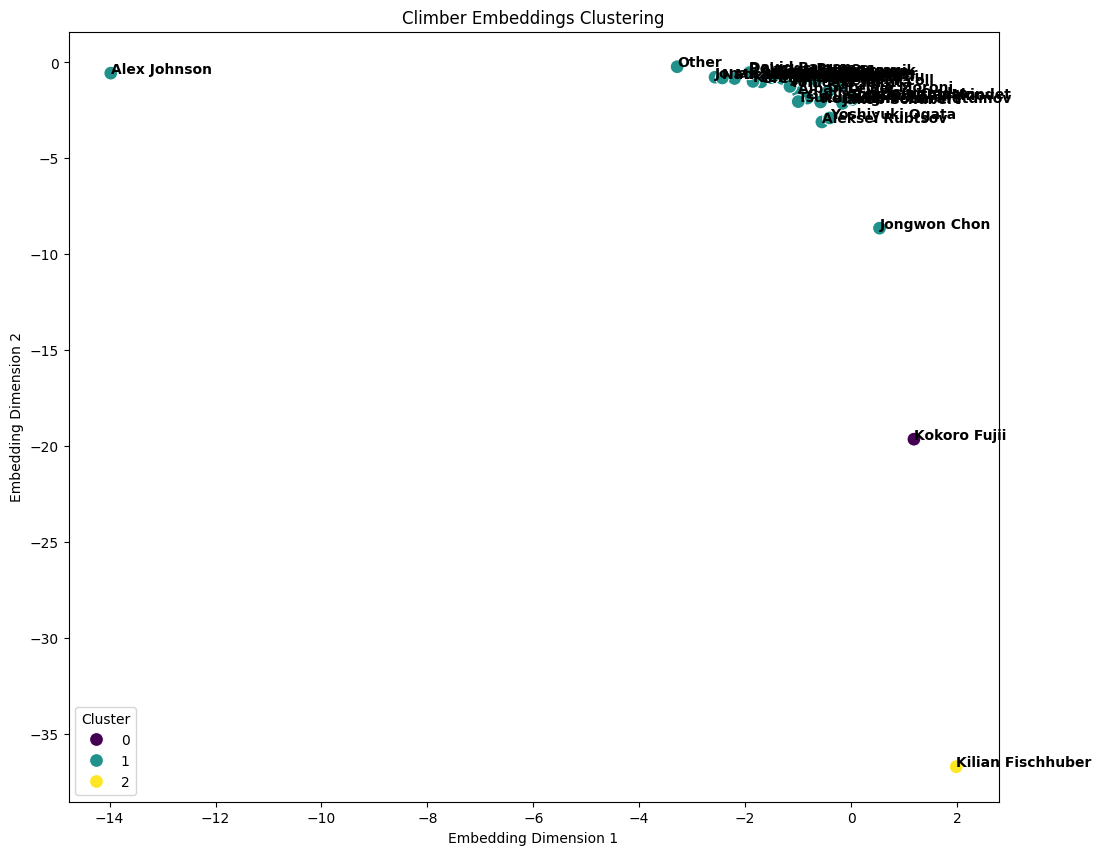

/var/folders/vw/h6mk20s92673927lzr84l52r0000gn/T/ipykernel_47898/3102733432.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(embeddings_df[0][line], embeddings_df[1][line], embeddings_df.index[line], horizontalalignment='left', size='medium', color='black', weight='semibold')


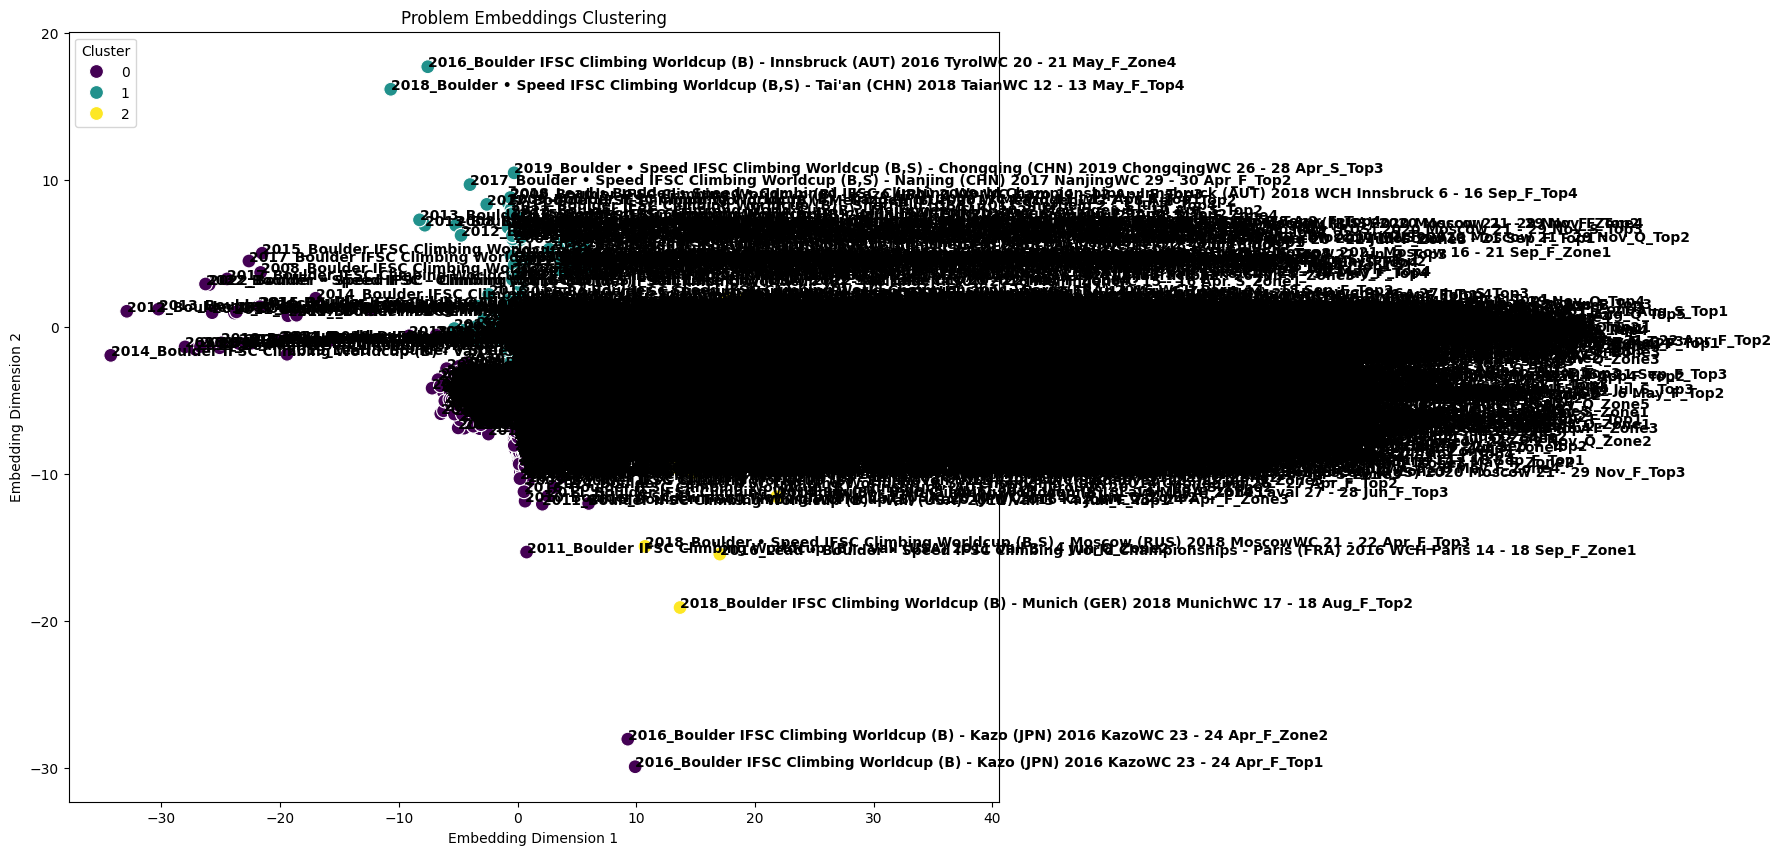

In [9]:
# Create a DataFrame to compare predicted vs test values
comparison_df = pd.DataFrame({
    'Actual': test_values.numpy(),
    'Predicted': test_predictions_binary
})

# Create the LabelEncoders used in the preprocessing
climber_encoder = LabelEncoder().fit(train[f'Climber_{threshold}'].astype(str).unique())
problem_encoder = LabelEncoder().fit(train['Stratification'].astype(str).unique())

# Map the original codes back to their names for embeddings
climber_embeddings_df = extract_embeddings(model, climber_encoder, model.climber_embedding, 'Climber')
problem_embeddings_df = extract_embeddings(model, problem_encoder, model.problem_embedding, 'Problem')

# Visualize the clustered embeddings
cluster_and_visualize(climber_embeddings_df, 'Climber Embeddings Clustering')
cluster_and_visualize(problem_embeddings_df, 'Problem Embeddings Clustering')